In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%capture
!pip install captum
from captum.attr import DeepLift, IntegratedGradients
!pip install torchsummary
from torchvision import models
from torchsummary import summary
batch_size = 128
num_epochs = 12

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.3),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(12*12*64, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 12*12*64)
        x = self.fc_layers(x)
        return x

In [5]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # print(data.shape, type(data))
        output = model(data)
        # print(output.shape, type(output))
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index in [1] of the max log-probability (max, max_index)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [6]:
%%capture
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

In [7]:
model = Net().to(device)

In [8]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
           Dropout-6           [-1, 64, 12, 12]               0
            Linear-7                   [-1, 50]         460,850
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
          Softmax-11                   [-1, 10]               0
Total params: 480,176
Trainable params: 480,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
model = Net().to(device)
checkpoint = torch.load("/content/drive/MyDrive/model12.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.7)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])\

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
Captum_DeepLIFT = DeepLift(model)

In [12]:
example_data, example_targets = example_data.cuda(), example_targets.cuda()

In [14]:
image = example_data[0]
image.requires_grad_()

attribution = Captum_DeepLIFT.attribute(image.unsqueeze(0), target=example_targets[0])
attribution = attribution.cpu()
attribution.detach()
attribution = attribution[0]

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


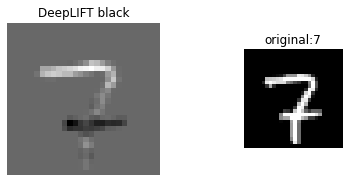

In [18]:
# attribution.shape
# print(example_targets[0])
# tensor_image.permute(1, 2, 0)


fig = plt.figure()

plt.subplot(1,2,1)
plt.title('DeepLIFT black')
plt.axis('off')
plt.imshow(attribution[0].detach().numpy(), cmap='gray', interpolation='none')

plt.subplot(1,3,3)
plt.title('original:{}'.format(example_targets[0]))
plt.axis('off')
plt.imshow(image[0].cpu().detach().numpy(), cmap='gray', interpolation='none')

plt.tight_layout()
plt.show()
fig.savefig('out.png', dpi=100)

In [ ]:
# use .cuda(), .cpu() on tensor to get in new location

In [ ]:
# num_steps = 50
# step_sizes = torch.linspace(0, 1, steps=num_steps+1)
# device = torch.device('cpu')
# @torch.jit.script
def interpolation_points(base, final, n):
    base_interp = base.unsqueeze(0)
    final_interp = final.unsqueeze(0)
    steps = torch.linspace(0, 1, steps=n, device=base.device)
    for _ in range(base.ndim):
        steps = steps.unsqueeze(-1)
    return base_interp+(final_interp-base_interp)*steps

In [ ]:
fig = plt.figure(figsize=(20, 20))
sample = data[0][0]
baseline = torch.zeros_like(sample)
i = 0
# for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
interpolated_images = interpolation_points(baseline, sample, 10)
outputs = model(interpolated_images)
print(outputs.shape)
for image in interpolated_images:
  i += 1
  plt.subplot(1, 10+1, i)
  plt.title(f'alpha: {(i-1)/10:.1f}')
  plt.imshow(image, vmin=0, vmax=1)
  plt.axis('off')

plt.tight_layout()